In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
from qiskit.quantum_info import pauli_basis, PTM

home_folder = os.getcwd()
while not home_folder.endswith("AutomatedPERTools"):
    home_folder = os.path.dirname(home_folder)
sys.path.append(os.path.join(home_folder, "pauli_lindblad_per"))
import pickle

In [2]:
def decipher_name(namebase):
    dic = dict()
    split_namebase = namebase.split("_")
    #parser.add_argument('--plusone', '-p', help='Takes Neighboring qubits into account', default=False, action='store_true')
    dic["tomography_connections"] = (split_namebase[0] == "True")
    #parser.add_argument('--sum', '-s', help='Same as -p and turns sumation on over neighboring qubits', default=False, action='store_true')
    dic["sum_over_lambda"] = (split_namebase[1] == "True")
    if dic["sum_over_lambda"]:
        dic["tomography_connections"] = True
    #parser.add_argument('--pntsamples', type=int, help='How many samples in PNT? Default: 16', default=16)
    dic["pntsamples"] = int(split_namebase[2])
    #parser.add_argument('--pntsinglesamples', type=int, help='How many single samples in PNT? Default: 100', default=100)
    dic["pntsinglesamples"] = int(split_namebase[3])
    #parser.add_argument('--persamples', type=int, help='How many samples in PER? Default: 100', default=100)
    dic["persamples"] = int(split_namebase[4])
    #parser.add_argument('--shots', type=int, help='How many shots? Default: 1000', default=1000)
    dic["shots"] = int(split_namebase[5])
    #parser.add_argument('--backend', type=str, help='Which backend to use? Default: FakeVigoV2', default="FakeVigoV2")
    import qiskit.providers.fake_provider as fake_provider
    backend = fake_provider.FakeVigoV2()
    if split_namebase[6] != "FakeVigoV2":
        method = getattr(fake_provider, split_namebase[6])
        backend = method()
    dic["backend"] = backend

    #parser.add_argument('--cross', '-c', help='Simulates Cross Talk Noise', default=False, action='store_true')
    dic["do_cross_talk_noise"] = (split_namebase[7] == "True")
    #parser.add_argument('--allqubits', '-a', help='runs over all qubits in the tomography', default=False, action='store_true')
    dic["allqubits"] = (split_namebase[8] == "True")
    #parser.add_argument('--onlyTomography', help='Only does the tomography and then ends the program', default=False, action='store_true')
    dic["onlyTomography"] = (split_namebase[9] == "True")

    #parser.add_argument('--setqubits', type=int, nargs='+', help='Which qubits to use?: Default: 0123 and transpile')
    import ast
    dic["qubits"]= ast.literal_eval(split_namebase[10])
    if dic["qubits"] !=  [0,1,2,3]:
        dic["num_qubits"] = backend.num_qubits    
    else:
        dic["num_qubits"] = len(dic["qubits"])
    #if split_namebase[7] == '[0,1,2,3]' and split_namebase[8] == 'and' and split_namebase[9] == 'transpile':
    return dic

In [3]:
main_folder_path = "tutorial_notebooks/testrun/server_run_collection".split('/')
main_folder = ""
for segment in main_folder_path:
    main_folder = os.path.join(main_folder, segment)
folders = [f for f in os.listdir(os.path.join(home_folder, main_folder)) if os.path.isdir(os.path.join(os.path.join(home_folder, main_folder), f))]
filtered_folders = [f for f in folders if "FakeVigoV2" in f 
                    and not decipher_name(f)["do_cross_talk_noise"] 
                    and decipher_name(f)["pntsamples"]== 256]
print(filtered_folders)

['False_False_256_4000_100_1024_FakeVigoV2_False_False_True_{1, 2, 3, 4}_[2, 4, 8, 16, 32, 64]', 'False_False_256_4000_100_1024_FakeVigoV2_False_True_True_{1, 2, 3, 4}_[2, 4, 8, 16, 32, 64]', 'True_False_256_4000_100_1024_FakeVigoV2_False_False_True_{1, 2, 3, 4}_[2, 4, 8, 16, 32, 64]']


In [4]:
coeffs_datas = []
infidelities_datas = []
for folder in filtered_folders:
    print(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "coeffs.pickle"))
    with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "coeffs.pickle"), "rb") as f:
        coeffs = pickle.load(f)
        coeffs_datas.append(coeffs)
    with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "infidelities.pickle"), "rb") as f:
        infidelities = pickle.load(f)
        infidelities_datas.append(infidelities)

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\tutorial_notebooks\testrun\server_run_collection\False_False_256_4000_100_1024_FakeVigoV2_False_False_True_{1, 2, 3, 4}_[2, 4, 8, 16, 32, 64]\coeffs.pickle
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\tutorial_notebooks\testrun\server_run_collection\False_False_256_4000_100_1024_FakeVigoV2_False_True_True_{1, 2, 3, 4}_[2, 4, 8, 16, 32, 64]\coeffs.pickle
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\tutorial_notebooks\testrun\server_run_collection\True_False_256_4000_100_1024_FakeVigoV2_False_False_True_{1, 2, 3, 4}_[2, 4, 8, 16, 32, 64]\coeffs.pickle


In [5]:
with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),filtered_folders[0]), "noise_model.pickle"), "rb") as f:
    (noise_model, twoqubit_error, singlequbit_error) = pickle.load(f)
from TrotterExample import get_noise_model, make_initial_Circuit
(noise_model, twoqubit_error_template, singlequbit_error_template) = get_noise_model()
dic = decipher_name(filtered_folders[0])
backend = dic["backend"]
circuit = make_initial_Circuit(list(dic["qubits"]), dic["num_qubits"], backend, 2)[0]

In [6]:
def get_index(qc, inst, i=None):
    if i:
        qubit = inst.qubits[i]
        index = -1
        for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
            if qubit in register:
                index = register.index(qubit)
                break
        return index
    else:
        qubits = inst.qubits
        indexes = []
        for qubit in qubits:
            index = -1
            for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
                if qubit in register:
                    index = register.index(qubit)
                    break
            indexes.append(index)
        return indexes

In [7]:
from TrotterExample import circuit_to_layers
from primitives.circuit import QiskitCircuit

layers = circuit_to_layers(QiskitCircuit(circuit))

In [8]:
def get_error_for_circuit(circuit, twoqubit_error_template, singlequbit_error_template, backend):
    from qiskit.quantum_info import Pauli
    def mul_Pauli(pauli1, pauli2):
        result = pauli1.compose(pauli2)
        nophase = Pauli((result.z, result.x))
        return nophase

    num_qubits = backend.num_qubits
    identity_string = 'I'*num_qubits
    error_state = {Pauli(identity_string): 1}
    for inst in circuit:
        temp_error_state = {}
        indexes = get_index(circuit, inst)
        if len(indexes) == 1:
            index = indexes[0]
            for (op, p) in singlequbit_error_template:
                op = Pauli("".join(reversed(identity_string[:index] + str(op)+ identity_string[index+1:])))
                for og_op in error_state:
                    og_p = error_state[og_op]
                    new_op = mul_Pauli(op, og_op)
                    temp_error_state[new_op] = temp_error_state.get(new_op, 0) + p*og_p
        elif len(indexes) == 2:
            for (op, p) in twoqubit_error_template:
                temp_string = (identity_string[:indexes[0]] + "".join(reversed(str(op)))[0]+ identity_string[indexes[0]+1:])
                op = Pauli("".join(reversed(temp_string[:indexes[1]] + "".join(reversed(str(op)))[1]+ temp_string[indexes[1]+1:])))
                for og_op in error_state:
                    og_p = error_state[og_op]
                    new_op = mul_Pauli(op, og_op)
                    temp_error_state[new_op] = temp_error_state.get(new_op, 0) + p*og_p
        else:
            if inst.operation.name == 'barrier':
                continue
            raise Exception("Too many qubits")
        error_state = temp_error_state
    return [(op, error_state[op]) for op in error_state]

In [9]:
def model_terms(layer, *list):
    return layer._model_terms(list)

In [10]:
def splice_string(string, indexes):
    for index in sorted(indexes):
        index -= sorted(indexes).index(index)
        string = string[:index]+string[index+1:]
    return string

In [11]:
choosen_qubits = [3,4]
coe = True
layer_number = 0
groups = []
for qubit in choosen_qubits:
    groups += [pauli for pauli in pauli_basis(backend.num_qubits) if str(pauli)[::-1][qubit] != 'I' and (splice_string(str(pauli)[::-1], [qubit]) == 'I'*(backend.num_qubits-1))]
groups += [pauli for pauli in pauli_basis(backend.num_qubits) if str(pauli)[::-1][choosen_qubits[0]] != 'I' and str(pauli)[::-1][choosen_qubits[1]] != 'I' and (splice_string(str(pauli)[::-1], [choosen_qubits[0], choosen_qubits[1]]) == 'I'*(backend.num_qubits-2))]

In [12]:
from qiskit.quantum_info import Pauli
singlequbit_error_template = [(Pauli('I'), 1)]
singlequbit_error_template

[(Pauli('I'), 1)]

In [17]:
from qiskit.providers.aer.noise import pauli_error
true_error_template = {pauli: error for pauli, error in get_error_for_circuit(layers[layer_number].qc, twoqubit_error_template, singlequbit_error_template, backend)}
true_error = pauli_error(get_error_for_circuit(layers[layer_number].qc, twoqubit_error_template, singlequbit_error_template, backend))

In [18]:
transfer_matrix = None
for folder in filtered_folders:
    if os.path.exists(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrixes.pickle")):
        with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrixes.pickle"), "rb") as f:
            transfer_matrixes = pickle.load(f)
            transfer_matrix = transfer_matrixes[layer_number]

if not transfer_matrix:
    for folder in filtered_folders:
        if os.path.exists(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrix.pickle")):
            with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrix.pickle"), "rb") as f:
                (transfer_matrix, saved_layer_number) = pickle.load(f)
                if saved_layer_number != layer_number:
                    transfer_matrix = None
                      
if not transfer_matrix:
    transfer_matrix = PTM(true_error.to_quantumchannel()).data #Find out more about this
    
for folder in filtered_folders:
    with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrix.pickle"), "wb") as f:
        pickle.dump((transfer_matrix, layer_number), f)

In [14]:
infidelities_list = []
coeffs_list = []
labels = []
stack = {pauli: (1-transfer_matrix[i][i]).real for i,pauli in enumerate(pauli_basis(backend.num_qubits))}
stack = [stack[pauli] for pauli in groups]
infidelities_list.append(stack)
coeffs_list.append([true_error_template.get(pauli, 0) for pauli in groups])
labels.append("Real Error")

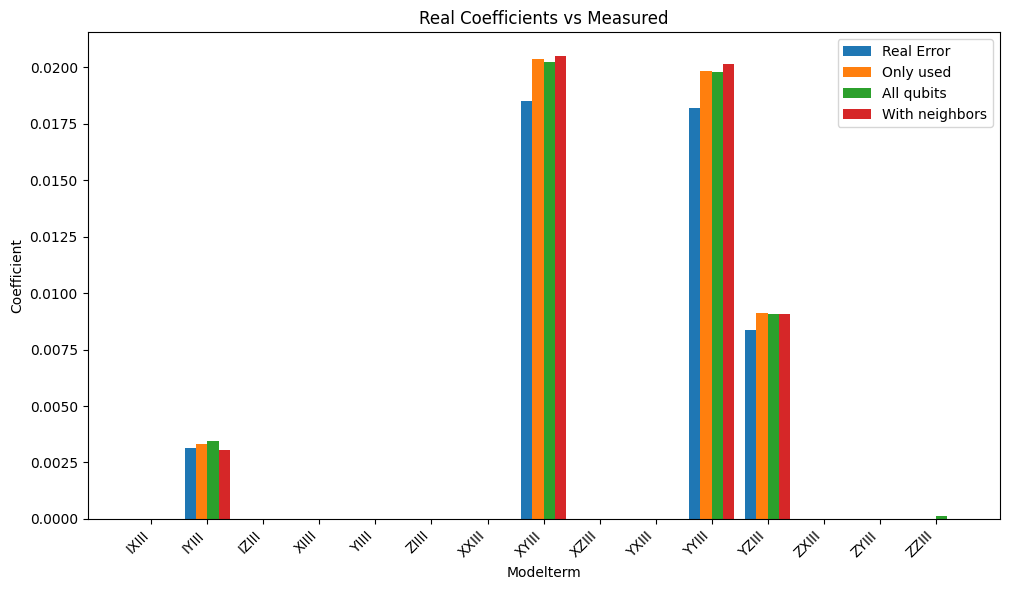

In [15]:
for array_of_coeffs, array_of_infidelities, folder in zip(coeffs_datas, infidelities_datas, filtered_folders):
    coeffs = array_of_coeffs[layer_number]
    infidelities = array_of_infidelities[layer_number]
    cipher = decipher_name(folder)
    if cipher["tomography_connections"]:
        labels.append("With neighbors")
    elif cipher["allqubits"]:
        labels.append("All qubits")
    else:
        labels.append("Only used")
    #print("tomography_connections", cipher["tomography_connections"])
    #print("allqubits", cipher["allqubits"])

    coeffs_list.append([coeffs[key] for key in groups])
    infidelities_list.append([infidelities[key] for key in groups])


#print([len(item) for item in infidelities_list])
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(groups))  # Label locations
width = 0.8 / (len(filtered_folders)+1)  # Width of the bars, adjusted for the number of datasets

# Create the bar plot

# Plotting bars for each folder's data dynamically
for i in range(len(filtered_folders)+1):
    if coe:
        ax.bar(x + (i - len(filtered_folders)/2) * width, coeffs_list[i], width, label=labels[i])
    else:
        ax.bar(x + (i - len(filtered_folders)/2) * width, infidelities_list[i], width, label=labels[i])

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Modelterm')
if coe:
    ax.set_title('Real Coefficients vs Measured')
else:
    ax.set_title('Real Infidelity vs Measured')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha='right')

# Add legend
ax.legend()

# Display the plot
plt.tight_layout()
#plt.show()
if coe:
    ax.set_ylabel('Coefficient')
    plt.savefig("Coefficient")
else:
    ax.set_ylabel('Infidelity')
    plt.savefig("Infidelity")